# PT-JPL Sensitivity Analysis with ECOv002 Cal-Val

This notebook performs a sensitivity analysis of the PT-JPL model using ECOSTRESS Collection 2 Cal-Val data. It loads input data, processes it through the PT-JPL model, and visualizes the impact of input perturbations on latent heat flux. The notebook also generates figures for publication and explores the relationship between surface temperature and latent heat flux.

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the PT-JPL model, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

In [2]:
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from PTJPL import process_PTJPL_table, load_ECOv002_calval_PTJPL_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Set Normalization Function

This cell assigns the normalization function used to compare perturbed model outputs to the unperturbed baseline. The function `divide_absolute_by_unperturbed` is used for normalization in the sensitivity analysis.

In [3]:
normalization_function = divide_absolute_by_unperturbed

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function and filters out rows where `fAPARmax` is zero. The resulting DataFrame is displayed for inspection.

In [4]:
input_df = load_ECOv002_calval_PTJPL_inputs()
input_df = input_df[input_df.fAPARmax != 0]
input_df

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,geometry,time_UTC,ST_K,ST_C,Ta_C,SWin_Wm2,emissivity,name,Topt_C,fAPARmax
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,POINT (-76.656 35.799),2019-10-02 19:09:40,305.10,31.95,32.658920,545.51056,0.948,NC_Clearcut#3,10.09,0.4659
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,POINT (-80.637 41.8222),2019-06-23 18:17:17,304.34,31.19,24.227982,848.34390,0.952,LTAR UCB (Upper Chesapeake Bay) Miscanthus 3,1.39,0.4865
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,POINT (-80.637 41.8222),2019-06-27 16:35:42,304.06,30.91,26.178862,838.81160,0.972,LTAR UCB (Upper Chesapeake Bay) Miscanthus 3,1.39,0.4865
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,POINT (-80.637 41.8222),2019-06-30 15:44:10,301.80,28.65,22.527096,851.72480,0.974,LTAR UCB (Upper Chesapeake Bay) Miscanthus 3,1.39,0.4865
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,POINT (-80.637 41.8222),2019-07-01 14:53:48,303.18,30.03,23.280691,702.55160,0.960,LTAR UCB (Upper Chesapeake Bay) Miscanthus 3,1.39,0.4865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,POINT (-99.0588 35.4106),2021-12-11 16:01:12,278.78,5.63,3.815752,286.84660,0.980,NEON Klemme Range Research Station (OAES),7.99,0.3387
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,POINT (-99.0588 35.4106),2022-03-25 22:45:31,293.28,20.13,19.266186,290.87400,0.976,NEON Klemme Range Research Station (OAES),7.99,0.3387
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,POINT (-99.0588 35.4106),2022-04-12 22:53:09,301.94,28.79,32.110336,352.19530,0.976,NEON Klemme Range Research Station (OAES),7.99,0.3387
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,POINT (-99.0588 35.4106),2022-04-14 14:45:37,290.72,17.57,10.464681,420.67880,0.976,NEON Klemme Range Research Station (OAES),7.99,0.3387


## Check Minimum fAPARmax Value

This cell computes the minimum value of `fAPARmax` in the filtered input data to verify the filtering step and ensure no zero values remain.

In [5]:
np.nanmin(input_df.fAPARmax)

np.float64(0.2331)

## Define Processing Function for Model Table

This cell defines a helper function that processes the input DataFrame through the Verma net radiation calculation and then the PT-JPL model. This function is used in later analysis steps.

In [6]:
def process_verma_PTJPL_table(input_df: pd.DataFrame) -> pd.DataFrame:
    return process_PTJPL_table(verma_net_radiation_table(input_df))

## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the Verma net radiation and PT-JPL model, and displays the resulting DataFrame.

In [7]:
processed = process_verma_PTJPL_table(input_df)
processed

[2025-09-08 17:10:16 INFO] starting Verma net radiation processing
[2025-09-08 17:10:16 INFO] variable SWout_Wm2 min: 0.000 mean: 66.193 max: 278.058 nan: 0.00% (nan)
[2025-09-08 17:10:16 INFO] variable SWnet_Wm2 min: 0.000 mean: 540.741 max: 929.140 nan: 0.00% (nan)
[2025-09-08 17:10:16 INFO] variable LWin_Wm2 min: 175.737 mean: 343.651 max: 473.521 nan: 0.00% (nan)
[2025-09-08 17:10:16 INFO] variable LWout_Wm2 min: 240.846 mean: 462.295 max: 693.334 nan: 0.00% (nan)
[2025-09-08 17:10:16 INFO] variable Rn_Wm2 min: 0.000 mean: 422.206 max: 843.390 nan: 0.00% (nan)
[2025-09-08 17:10:16 INFO] variable Rn_daylight_Wm2 min: 0.000 mean: 257.722 max: 443.569 nan: 0.00% (nan)
[2025-09-08 17:10:16 INFO] Verma net radiation processing complete in 0.01 seconds


,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,LWout_Wm2,Rn_Wm2,Rn_daylight_Wm2,Rn_soil_Wm2,LE_soil_Wm2,Rn_canopy_Wm2,PET_Wm2,LE_canopy_Wm2,LE_interception_Wm2,LE_Wm2
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,465.788054,395.386594,236.387027,108.025913,16.547920,285.831187,348.579227,249.872119,0.029060,266.449099
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,463.110120,641.736047,332.853921,242.983670,41.693402,400.491330,518.484847,334.616839,0.036937,376.347178
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,471.101631,654.338979,337.738360,255.079320,89.714942,373.689380,518.782458,325.830086,0.035376,415.580404
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,458.191551,678.553376,366.977454,203.478663,76.937311,423.480937,505.753641,335.529206,0.038103,412.504620
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,459.922447,516.680516,303.069593,162.335322,47.807718,350.798478,413.852320,279.933774,0.031919,327.773411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,335.647726,162.251159,123.775635,121.450797,38.910376,41.796593,92.388700,16.172143,0.002426,55.084946
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,409.440488,166.366277,178.058285,131.899739,28.754699,34.292221,128.608037,23.325564,0.002926,52.083188
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,459.984925,256.512330,262.883413,171.573784,4.856571,64.307806,207.238994,58.667346,0.006504,63.530420
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,395.330786,246.524236,212.287292,180.002902,47.538057,67.875998,161.062364,43.339051,0.004795,90.881902


## Plot Unperturbed Comparison of Surface Temperature to Latent Heat Flux

This cell creates a scatter plot comparing ECOSTRESS surface temperature to PT-JPL latent heat flux for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

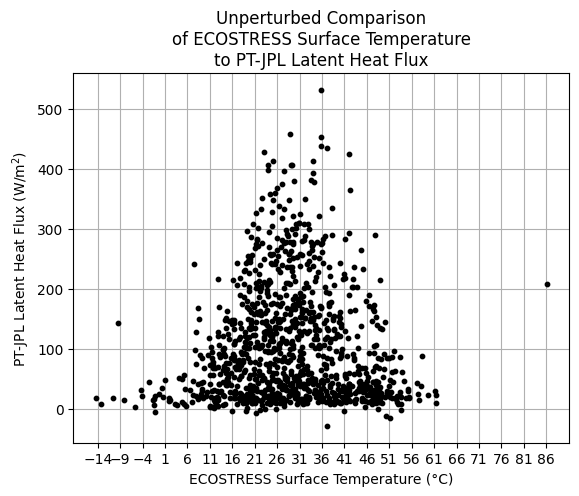

In [8]:
plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
plt.scatter(x=processed.ST_C, y=processed.LE, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel("PT-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto PT-JPL Latent Heat Flux")

plt.savefig("Unperturbed Comparison of ECOSTRESS Surface Temperature to PT-JPL Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Unperturbed Comparison of ECOSTRESS Surface Temperature to PT-JPL Latent Heat Flux.svg", format='svg', bbox_inches='tight')

plt.show()

## Further Filter Input Data and Check Temperature Range

This cell applies additional filters to the input data, ensuring only valid `fAPARmax` and `NDVI` values are included. It also checks the minimum and maximum surface temperature values in the filtered dataset.

In [9]:
# input_df = pd.read_csv(input_filename)
input_df = load_ECOv002_calval_PTJPL_inputs()

if "Ta" in input_df and "Ta_C" not in input_df:
    # input_df.rename({"Ta": "Ta_C"}, inplace=True)
    input_df["Ta_C"] = input_df["Ta"]

input_df = input_df[input_df.fAPARmax.apply(lambda fAPARmax: fAPARmax > 0.001)]
input_df = input_df[input_df.NDVI.apply(lambda NDVI: NDVI > 0.05)]

np.nanmin(input_df.ST_C), np.nanmax(input_df.ST_C)

(np.float64(-13.189999999999998), np.float64(86.11000000000001))

## Check Number of Valid Input Rows

This cell displays the number of rows remaining in the input DataFrame after all filtering steps, confirming the size of the dataset used for analysis.

In [10]:
len(input_df)

1063

## Run Perturbed Model Analysis

This cell sets up the input and output variables for the sensitivity analysis and runs the `perturbed_run` function, which perturbs the input variable and observes the effect on the output variable using the PT-JPL model. The results are displayed for further analysis.

In [11]:
input_variable = "ST_C"
output_variable = "LE_Wm2"

results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_verma_PTJPL_table,
    normalization_function=normalization_function
)

results

[2025-09-08 17:10:16 INFO] tarting Monte Carlo perturbed run
[2025-09-08 17:10:16 INFO] calculating standard deviation of input variable: ST_C
[2025-09-08 17:10:16 INFO] input variable ST_C standard deviation: 12.285657205245933
[2025-09-08 17:10:16 INFO] starting forward process
[2025-09-08 17:10:16 INFO] starting Verma net radiation processing
[2025-09-08 17:10:16 INFO] variable SWout_Wm2 min: 0.000 mean: 65.951 max: 278.058 nan: 0.00% (nan)
[2025-09-08 17:10:16 INFO] variable SWnet_Wm2 min: 0.000 mean: 541.474 max: 929.140 nan: 0.00% (nan)
[2025-09-08 17:10:16 INFO] variable LWin_Wm2 min: 175.737 mean: 343.933 max: 473.521 nan: 0.00% (nan)
[2025-09-08 17:10:16 INFO] variable LWout_Wm2 min: 248.604 mean: 462.692 max: 693.334 nan: 0.00% (nan)
[2025-09-08 17:10:16 INFO] variable Rn_Wm2 min: 0.000 mean: 422.824 max: 843.390 nan: 0.00% (nan)
[2025-09-08 17:10:16 INFO] variable Rn_daylight_Wm2 min: 0.000 mean: 258.106 max: 443.569 nan: 0.00% (nan)
[2025-09-08 17:10:16 INFO] Verma net radi

,input_variable,output_variable,input_unperturbed,input_perturbation,input_perturbation_std,input_perturbed,output_unperturbed,output_perturbation,output_perturbation_std,output_perturbed
0,ST_C,LE_Wm2,31.95,-19.100882,0.597837,12.849118,266.449099,8.84807,0.033207,275.297169
1,ST_C,LE_Wm2,31.95,21.772533,0.681456,53.722533,266.449099,-10.085654,0.037852,256.363445
2,ST_C,LE_Wm2,31.95,0.340279,0.010650,32.290279,266.449099,-0.157627,0.000592,266.291472
3,ST_C,LE_Wm2,31.95,22.070470,0.690782,54.02047,266.449099,-10.223667,0.03837,256.225432
4,ST_C,LE_Wm2,31.95,-14.784593,0.462742,17.165407,266.449099,6.848642,0.025703,273.297742
...,...,...,...,...,...,...,...,...,...,...
106295,ST_C,LE_Wm2,41.61,21.872182,0.525647,63.482182,152.810388,-4.28076,0.028014,148.529628
106296,ST_C,LE_Wm2,41.61,-15.927049,0.382770,25.682951,152.810388,3.117196,0.020399,155.927583
106297,ST_C,LE_Wm2,41.61,-3.242880,0.077935,38.36712,152.810388,0.634687,0.004153,153.445075
106298,ST_C,LE_Wm2,41.61,3.808908,0.091538,45.418908,152.810388,-0.745468,0.004878,152.064919


## Filter Out NaN Results

This cell removes any rows with missing values from the perturbed results to ensure only valid data points are used in subsequent analysis and plotting.

In [12]:
filtered_results = results.dropna()
filtered_results

,input_variable,output_variable,input_unperturbed,input_perturbation,input_perturbation_std,input_perturbed,output_unperturbed,output_perturbation,output_perturbation_std,output_perturbed
0,ST_C,LE_Wm2,31.95,-19.100882,0.597837,12.849118,266.449099,8.84807,0.033207,275.297169
1,ST_C,LE_Wm2,31.95,21.772533,0.681456,53.722533,266.449099,-10.085654,0.037852,256.363445
2,ST_C,LE_Wm2,31.95,0.340279,0.010650,32.290279,266.449099,-0.157627,0.000592,266.291472
3,ST_C,LE_Wm2,31.95,22.070470,0.690782,54.02047,266.449099,-10.223667,0.03837,256.225432
4,ST_C,LE_Wm2,31.95,-14.784593,0.462742,17.165407,266.449099,6.848642,0.025703,273.297742
...,...,...,...,...,...,...,...,...,...,...
106295,ST_C,LE_Wm2,41.61,21.872182,0.525647,63.482182,152.810388,-4.28076,0.028014,148.529628
106296,ST_C,LE_Wm2,41.61,-15.927049,0.382770,25.682951,152.810388,3.117196,0.020399,155.927583
106297,ST_C,LE_Wm2,41.61,-3.242880,0.077935,38.36712,152.810388,0.634687,0.004153,153.445075
106298,ST_C,LE_Wm2,41.61,3.808908,0.091538,45.418908,152.810388,-0.745468,0.004878,152.064919


## Plot Change in Surface Temperature vs Latent Heat Flux

This cell generates a scatter plot showing the relationship between changes in surface temperature and changes in PT-JPL latent heat flux due to input perturbations. The plot is saved as JPEG and SVG files.

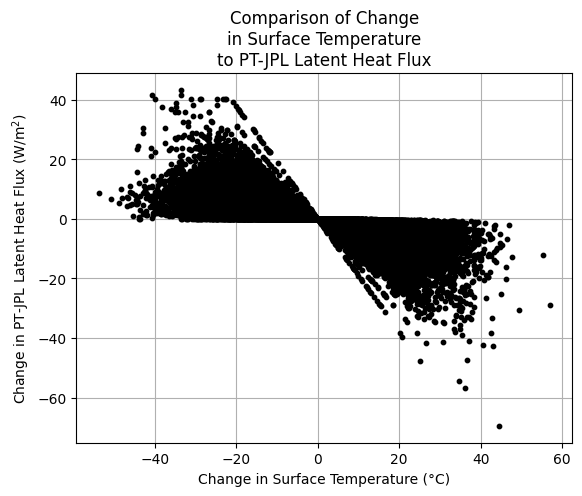

In [13]:
# plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
# plt.ylim(-350, 150)
plt.scatter(x=results.input_perturbation, y=results.output_perturbation, color='black', s=10, zorder=5)  # Adjust the 's' parameter to make dots thinner
plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel("Change in PT-JPL Latent Heat Flux (W/m$^2$)")
plt.title("Comparison of Change\nin Surface Temperature\nto PT-JPL Latent Heat Flux")

plt.savefig("Comparison of Change in Surface Temperature to PT-JPL Latent Heat Flux.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("Comparison of Change in Surface Temperature to PT-JPL Latent Heat Flux.svg", format='svg', bbox_inches='tight')

plt.show()

## Compute Correlation Between Input and Output Perturbations

This cell calculates the Pearson correlation coefficient between the standardized input and output perturbations, quantifying the strength of their linear relationship.

In [14]:
correlation = mstats.pearsonr(
    np.array(filtered_results.input_perturbation_std).astype(np.float64), 
    np.array(filtered_results.output_perturbation_std).astype(np.float64)
)[0]

correlation

np.float64(0.17264621300274746)

## Run Full Sensitivity Analysis for Multiple Inputs

This cell performs a comprehensive sensitivity analysis by perturbing several input variables (surface temperature, NDVI, albedo, air temperature, relative humidity) and measuring their effect on latent heat flux. The results are summarized in a DataFrame.

In [15]:
input_variables = ["ST_C", "NDVI", "albedo", "Ta_C", "RH"]
output_variables = ["LE_Wm2"]

perturbation_df, sensitivity_metrics_df = sensitivity_analysis(
    input_df=input_df,
    input_variables=input_variables,
    output_variables=output_variables,
    forward_process=process_verma_PTJPL_table,
    normalization_function=normalization_function
)

sensitivity_metrics_df

[2025-09-08 17:10:20 INFO] tarting Monte Carlo perturbed run
[2025-09-08 17:10:20 INFO] calculating standard deviation of input variable: ST_C
[2025-09-08 17:10:20 INFO] input variable ST_C standard deviation: 12.285657205245933
[2025-09-08 17:10:20 INFO] starting forward process
[2025-09-08 17:10:20 INFO] starting Verma net radiation processing
[2025-09-08 17:10:20 INFO] variable SWout_Wm2 min: 0.000 mean: 65.951 max: 278.058 nan: 0.00% (nan)
[2025-09-08 17:10:20 INFO] variable SWnet_Wm2 min: 0.000 mean: 541.474 max: 929.140 nan: 0.00% (nan)
[2025-09-08 17:10:20 INFO] variable LWin_Wm2 min: 175.737 mean: 343.933 max: 473.521 nan: 0.00% (nan)
[2025-09-08 17:10:20 INFO] variable LWout_Wm2 min: 248.604 mean: 462.692 max: 693.334 nan: 0.00% (nan)
[2025-09-08 17:10:20 INFO] variable Rn_Wm2 min: 0.000 mean: 422.824 max: 843.390 nan: 0.00% (nan)
[2025-09-08 17:10:20 INFO] variable Rn_daylight_Wm2 min: 0.000 mean: 258.106 max: 443.569 nan: 0.00% (nan)
[2025-09-08 17:10:20 INFO] Verma net radi

/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.10/site-packages/monte_carlo_sensitivity/sensitivity_analysis.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perturbation_df = pd.concat([perturbation_df, run_results])
/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.10/site-packages/monte_carlo_sensitivity/sensitivity_analysis.py:89: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sensitivity_metrics_df = pd.concat([sensitivity_metrics_df, pd.DataFrame([[


[2025-09-08 17:10:23 INFO] starting Verma net radiation processing
[2025-09-08 17:10:23 INFO] variable SWout_Wm2 min: 0.000 mean: 65.951 max: 278.058 nan: 0.00% (nan)
[2025-09-08 17:10:23 INFO] variable SWnet_Wm2 min: 0.000 mean: 541.474 max: 929.140 nan: 0.00% (nan)
[2025-09-08 17:10:23 INFO] variable LWin_Wm2 min: 175.737 mean: 343.933 max: 473.521 nan: 0.00% (nan)
[2025-09-08 17:10:23 INFO] variable LWout_Wm2 min: 248.604 mean: 462.692 max: 693.334 nan: 0.00% (nan)
[2025-09-08 17:10:23 INFO] variable Rn_Wm2 min: 0.000 mean: 422.824 max: 843.390 nan: 0.00% (nan)
[2025-09-08 17:10:24 INFO] variable Rn_daylight_Wm2 min: 0.000 mean: 258.106 max: 443.569 nan: 0.00% (nan)
[2025-09-08 17:10:24 INFO] Verma net radiation processing complete in 1.03 seconds
[2025-09-08 17:10:24 INFO] completed forward process for perturbed input
[2025-09-08 17:10:24 INFO] normalizing output perturbations
[2025-09-08 17:10:24 INFO] Monte Carlo run complete


/opt/homebrew/Caskroom/miniforge/base/envs/PTJPL/lib/python3.10/site-packages/carlson_leaf_area_index/carlson_leaf_area_index.py:66: RuntimeWarning: divide by zero encountered in log
  LAI = rt.clip(-np.log(1 - fIPAR) * (1 / KPAR), min_LAI, max_LAI)  # Beer-Lambert law for canopy


[2025-09-08 17:10:24 INFO] tarting Monte Carlo perturbed run
[2025-09-08 17:10:24 INFO] calculating standard deviation of input variable: albedo
[2025-09-08 17:10:24 INFO] input variable albedo standard deviation: 0.05366279984322165
[2025-09-08 17:10:24 INFO] starting forward process
[2025-09-08 17:10:24 INFO] starting Verma net radiation processing
[2025-09-08 17:10:24 INFO] variable SWout_Wm2 min: 0.000 mean: 65.951 max: 278.058 nan: 0.00% (nan)
[2025-09-08 17:10:24 INFO] variable SWnet_Wm2 min: 0.000 mean: 541.474 max: 929.140 nan: 0.00% (nan)
[2025-09-08 17:10:24 INFO] variable LWin_Wm2 min: 175.737 mean: 343.933 max: 473.521 nan: 0.00% (nan)
[2025-09-08 17:10:24 INFO] variable LWout_Wm2 min: 248.604 mean: 462.692 max: 693.334 nan: 0.00% (nan)
[2025-09-08 17:10:24 INFO] variable Rn_Wm2 min: 0.000 mean: 422.824 max: 843.390 nan: 0.00% (nan)
[2025-09-08 17:10:24 INFO] variable Rn_daylight_Wm2 min: 0.000 mean: 258.106 max: 443.569 nan: 0.00% (nan)
[2025-09-08 17:10:24 INFO] Verma net

,input_variable,output_variable,metric,value
0,ST_C,LE_Wm2,correlation,0.173754
0,ST_C,LE_Wm2,r2,0.030191
0,ST_C,LE_Wm2,mean_normalized_change,0.019455
0,NDVI,LE_Wm2,correlation,0.792652
0,NDVI,LE_Wm2,r2,0.628298
0,NDVI,LE_Wm2,mean_normalized_change,0.328613
0,albedo,LE_Wm2,correlation,0.467546
0,albedo,LE_Wm2,r2,0.218600
0,albedo,LE_Wm2,mean_normalized_change,0.003514
0,Ta_C,LE_Wm2,correlation,0.003731


## Plot Sensitivity Magnitude Bar Chart

This cell creates a bar chart showing the average percent change in latent heat flux for each input variable, visualizing the magnitude of model sensitivity to each input. The plot is saved as JPEG and SVG files with the PT-JPL label.

/var/folders/bv/410kt7f93x78j9dww00h1pz80000gn/T/ipykernel_70999/2845284750.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])


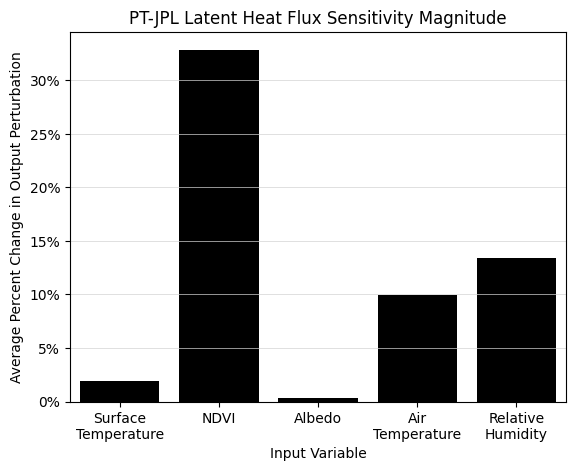

In [16]:
df = sensitivity_metrics_df
df = df[(df.output_variable == "LE_Wm2") & (df.metric == "mean_normalized_change")]
ax = sns.barplot(x=df.input_variable, y=df.value * 100, color='black')
ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])
plt.xlabel("Input Variable")
plt.ylabel("Average Percent Change in Output Perturbation")
plt.title("PT-JPL Latent Heat Flux Sensitivity Magnitude")
# plt.ylim(0, 160)  # Set y-axis range from 0 to 160
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5)  # Add light gray horizontal gridlines only

# Add percent sign to y-axis tick labels
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))

plt.savefig("PT-JPL Latent Heat Flux Sensitivity Magnitude.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("PT-JPL Latent Heat Flux Sensitivity Magnitude.svg", format='svg', bbox_inches='tight')

plt.show()

## Plot Sensitivity Correlation Bar Chart

This cell generates a bar chart showing the correlation between input perturbations and output perturbations for each input variable, highlighting which inputs most strongly influence latent heat flux. The plot is saved as JPEG and SVG files with the PT-JPL label.

/var/folders/bv/410kt7f93x78j9dww00h1pz80000gn/T/ipykernel_70999/4263481858.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])


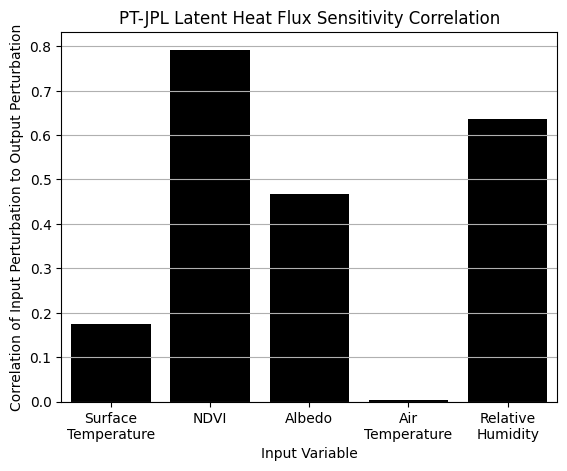

In [17]:
df = sensitivity_metrics_df
df = df[(df.output_variable == "LE_Wm2") & (df.metric == "correlation")]
ax = sns.barplot(x=df.input_variable, y=df.value, color='black')
ax.set_xticklabels(["Surface\nTemperature", "NDVI", "Albedo", "Air\nTemperature", "Relative\nHumidity"])
# plt.ylim(0, 0.8)
plt.xlabel("Input Variable")
plt.ylabel("Correlation of Input Perturbation to Output Perturbation")
plt.title("PT-JPL Latent Heat Flux Sensitivity Correlation")
plt.grid(axis='y')  # Add horizontal gridlines

plt.savefig("PT-JPL Latent Heat Flux Sensitivity Correlation.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig("PT-JPL Latent Heat Flux Sensitivity Correlation.svg", format='svg', bbox_inches='tight')

plt.show()

## Summary and Next Steps

This notebook demonstrated a full sensitivity analysis workflow for the PT-JPL model using ECOSTRESS Cal-Val data. Key results include the identification of input variables with the greatest influence on latent heat flux. Next steps could include further exploration of model parameters, additional visualizations, or application to other datasets.